# Importing necessary things

In [26]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from imblearn.over_sampling import ADASYN

import re
from datetime import datetime

==================================================================================================================

# Unpickling our data and taking a look

In [2]:
df = pd.read_pickle('reviewfeatures.pkl')
df

,title,installs,minInstalls,score,ratings,reviews,histogram,price,free,offersIAP,size,genre,genreId,released,contentRating
0,Among Us,"100,000,000+",100000000,4.474048,2132693.0,1101564.0,"[154333, 39857, 89011, 206765, 1642727]",0.00,True,True,70M,Action,GAME_ACTION,"Jun 15, 2018",Everyone 10+
1,Scribble Rider,"10,000,000+",10000000,3.884314,219513.0,91620.0,"[39359, 11409, 15784, 21673, 131288]",0.00,True,True,123M,Action,GAME_ACTION,"Jul 23, 2020",Everyone
2,Call of Duty®: Mobile,"100,000,000+",100000000,4.478313,10757089.0,4953322.0,"[783831, 203300, 401111, 1064381, 8304466]",0.00,True,True,94M,Action,GAME_ACTION,"Sep 30, 2019",Mature 17+
3,Hitmasters,"50,000,000+",50000000,4.090488,280248.0,98967.0,"[39272, 10530, 17919, 30372, 182155]",0.00,True,True,85M,Action,GAME_ACTION,"Mar 19, 2020",Teen
4,Draw Defence,"500,000+",500000,3.910000,1080.0,425.0,"[227, 21, 54, 97, 681]",0.00,True,False,76M,Action,GAME_ACTION,"Aug 27, 2020",Everyone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5130,Dropwords 2,"1,000+",1000,4.452381,42.0,17.0,"[1, 2, 2, 9, 28]",0.99,False,False,16M,Word,GAME_WORD,"Jul 22, 2014",Everyone
5131,CrossCraze PRO,"10,000+",10000,4.676190,1061.0,627.0,"[10, 30, 50, 111, 860]",5.49,False,False,21M,Word,GAME_WORD,"Mar 22, 2013",Everyone
5132,Word Breaker Full,"10,000+",10000,4.160000,1109.0,588.0,"[66, 33, 166, 233, 611]",2.99,False,False,14M,Word,GAME_WORD,"Feb 24, 2011",Everyone
5133,Spelling Challenge PRO,100+,100,0.000000,NaN,0.0,"[0, 0, 0, 0, 0]",1.99,False,False,Varies with device,Word,GAME_WORD,"Jun 18, 2019",Everyone


In [3]:
df.columns

Index(['title', 'installs', 'minInstalls', 'score', 'ratings', 'reviews',
       'histogram', 'price', 'free', 'offersIAP', 'size', 'genre', 'genreId',
       'released', 'contentRating'],
      dtype='object')

In [4]:
df.dtypes

title             object
installs          object
minInstalls        int64
score            float64
ratings          float64
reviews          float64
histogram         object
price            float64
free                bool
offersIAP           bool
size              object
genre             object
genreId           object
released          object
contentRating     object
dtype: object

In [5]:
# Will drop games with no ratings

df.isna().sum()

title             0
installs          0
minInstalls       0
score             5
ratings          85
reviews           5
histogram         0
price             0
free              0
offersIAP         0
size              0
genre             0
genreId           0
released         14
contentRating     0
dtype: int64

In [6]:
# 91 rows were removed.

df.dropna(inplace=True)

In [7]:
# Can probably drop this column as it's the same as minInstalls but in an object format.

df['installs'].value_counts()

1,000,000+        895
10,000,000+       858
100,000+          664
10,000+           664
5,000,000+        424
500,000+          301
50,000+           283
1,000+            280
5,000+            216
50,000,000+       197
100,000,000+      132
100+               55
500+               51
500,000,000+        9
50+                 6
10+                 4
1,000,000,000+      2
Name: installs, dtype: int64

In [8]:
# Possibly reduce this columns to fewer categories.

df['minInstalls'].value_counts()

1000000       895
10000000      858
10000         664
100000        664
5000000       424
500000        301
50000         283
1000          280
5000          216
50000000      197
100000000     132
100            55
500            51
500000000       9
50              6
10              4
1000000000      2
Name: minInstalls, dtype: int64

In [9]:
# We are only looking at the apps listed in the Top Free and Top Paid categories, so it makes sense the mean is high.

df['score'].describe()

count    5041.000000
mean        4.211683
std         0.418547
min         1.160000
25%         4.020566
50%         4.274995
75%         4.495050
max         5.000000
Name: score, dtype: float64

In [10]:
df['ratings'].describe()

count    5.041000e+03
mean     2.758921e+05
std      1.772676e+06
min      5.000000e+00
25%      1.150000e+03
50%      1.015100e+04
75%      7.912600e+04
max      6.302431e+07
Name: ratings, dtype: float64

In [11]:
df['reviews'].describe()

count    5.041000e+03
mean     1.084286e+05
std      8.181436e+05
min      1.000000e+00
25%      4.720000e+02
50%      4.026000e+03
75%      3.150300e+04
max      3.826257e+07
Name: reviews, dtype: float64

In [12]:
# Will reduce this columns to fewer categories.

df['price'].value_counts()

0.00     3346
2.99      325
0.99      272
4.99      252
1.99      239
3.99      165
6.99       57
9.99       45
3.49       41
1.49       41
5.99       37
5.49       35
2.49       32
7.99       28
4.49       19
8.99       14
14.99      11
19.99       7
6.49        7
15.99       7
1.00        6
13.99       5
24.99       4
1.96        4
7.49        4
11.99       4
17.99       3
12.99       3
2.00        2
5.00        2
29.99       2
1.79        2
3.75        1
3.63        1
1.50        1
4.29        1
20.99       1
1.02        1
2.69        1
3.89        1
32.99       1
1.95        1
5.60        1
4.40        1
1.20        1
2.29        1
2.19        1
1.39        1
18.99       1
8.49        1
1.19        1
1.90        1
Name: price, dtype: int64

In [13]:
# A decent number of these games are free games

df['free'].value_counts()

True     3346
False    1695
Name: free, dtype: int64

In [14]:
# Numbers are similar to whether games are free to play or not.
# Differences at a glance suggests a fair number of free games with no IAPs and paid games that still have IAPs

df['offersIAP'].value_counts()

True     3139
False    1902
Name: offersIAP, dtype: int64

In [15]:
df['size'].value_counts()

Varies with device    631
49M                    68
37M                    66
25M                    63
28M                    61
                     ... 
198M                    1
223M                    1
158M                    1
473M                    1
599M                    1
Name: size, Length: 269, dtype: int64

In [16]:
# Fair spread of games in each category.

df['genre'].value_counts()

Adventure       394
Role Playing    392
Simulation      389
Strategy        359
Puzzle          358
Educational     334
Action          333
Arcade          329
Board           292
Casual          292
Card            248
Sports          246
Racing          241
Word            217
Music           208
Casino          205
Trivia          204
Name: genre, dtype: int64

In [17]:
# Can remove this column as it's the same thing as genre.

df['genreId'].value_counts()

GAME_ADVENTURE       394
GAME_ROLE_PLAYING    392
GAME_SIMULATION      389
GAME_STRATEGY        359
GAME_PUZZLE          358
GAME_EDUCATIONAL     334
GAME_ACTION          333
GAME_ARCADE          329
GAME_BOARD           292
GAME_CASUAL          292
GAME_CARD            248
GAME_SPORTS          246
GAME_RACING          241
GAME_WORD            217
GAME_MUSIC           208
GAME_CASINO          205
GAME_TRIVIA          204
Name: genreId, dtype: int64

In [18]:
# Need to change this to a useable column.

df['released'].value_counts()

Jul 23, 2020    15
Apr 24, 2020    14
Aug 19, 2020    13
Jul 28, 2020    13
Aug 26, 2020    12
                ..
Jan 21, 2011     1
Jan 28, 2019     1
Jun 3, 2017      1
Oct 5, 2016      1
Aug 12, 2013     1
Name: released, Length: 2106, dtype: int64

In [19]:
# Most top apps are either for Everyone or Teen. Makes sense to appeal to wider audiences.

df['contentRating'].value_counts()

Everyone           3034
Teen               1279
Everyone 10+        561
Mature 17+          161
Adults only 18+       6
Name: contentRating, dtype: int64

==================================================================================================================

# Cleaning

In [20]:
df.drop(columns=['installs', 'genreId'], inplace=True)
df

,title,minInstalls,score,ratings,reviews,histogram,price,free,offersIAP,size,genre,released,contentRating
0,Among Us,100000000,4.474048,2132693.0,1101564.0,"[154333, 39857, 89011, 206765, 1642727]",0.00,True,True,70M,Action,"Jun 15, 2018",Everyone 10+
1,Scribble Rider,10000000,3.884314,219513.0,91620.0,"[39359, 11409, 15784, 21673, 131288]",0.00,True,True,123M,Action,"Jul 23, 2020",Everyone
2,Call of Duty®: Mobile,100000000,4.478313,10757089.0,4953322.0,"[783831, 203300, 401111, 1064381, 8304466]",0.00,True,True,94M,Action,"Sep 30, 2019",Mature 17+
3,Hitmasters,50000000,4.090488,280248.0,98967.0,"[39272, 10530, 17919, 30372, 182155]",0.00,True,True,85M,Action,"Mar 19, 2020",Teen
4,Draw Defence,500000,3.910000,1080.0,425.0,"[227, 21, 54, 97, 681]",0.00,True,False,76M,Action,"Aug 27, 2020",Everyone
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5128,Word Crack (Ad free),50000,4.225993,16368.0,7664.0,"[1335, 472, 1040, 3829, 9692]",2.99,False,True,56M,Word,"Oct 19, 2011",Everyone
5129,The Game Gal's Word Generator,1000,4.666666,12.0,6.0,"[0, 1, 0, 1, 10]",1.99,False,False,9.4M,Word,"Dec 25, 2017",Everyone
5130,Dropwords 2,1000,4.452381,42.0,17.0,"[1, 2, 2, 9, 28]",0.99,False,False,16M,Word,"Jul 22, 2014",Everyone
5131,CrossCraze PRO,10000,4.676190,1061.0,627.0,"[10, 30, 50, 111, 860]",5.49,False,False,21M,Word,"Mar 22, 2013",Everyone


In [25]:
df['releasedate'] = df['released'].apply(pd.to_datetime)
df.drop(columns=['released'], inplace=True)
df

,title,minInstalls,score,ratings,reviews,histogram,price,free,offersIAP,size,genre,contentRating,releasedate
0,Among Us,100000000,4.474048,2132693.0,1101564.0,"[154333, 39857, 89011, 206765, 1642727]",0.00,True,True,70M,Action,Everyone 10+,2018-06-15
1,Scribble Rider,10000000,3.884314,219513.0,91620.0,"[39359, 11409, 15784, 21673, 131288]",0.00,True,True,123M,Action,Everyone,2020-07-23
2,Call of Duty®: Mobile,100000000,4.478313,10757089.0,4953322.0,"[783831, 203300, 401111, 1064381, 8304466]",0.00,True,True,94M,Action,Mature 17+,2019-09-30
3,Hitmasters,50000000,4.090488,280248.0,98967.0,"[39272, 10530, 17919, 30372, 182155]",0.00,True,True,85M,Action,Teen,2020-03-19
4,Draw Defence,500000,3.910000,1080.0,425.0,"[227, 21, 54, 97, 681]",0.00,True,False,76M,Action,Everyone,2020-08-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5128,Word Crack (Ad free),50000,4.225993,16368.0,7664.0,"[1335, 472, 1040, 3829, 9692]",2.99,False,True,56M,Word,Everyone,2011-10-19
5129,The Game Gal's Word Generator,1000,4.666666,12.0,6.0,"[0, 1, 0, 1, 10]",1.99,False,False,9.4M,Word,Everyone,2017-12-25
5130,Dropwords 2,1000,4.452381,42.0,17.0,"[1, 2, 2, 9, 28]",0.99,False,False,16M,Word,Everyone,2014-07-22
5131,CrossCraze PRO,10000,4.676190,1061.0,627.0,"[10, 30, 50, 111, 860]",5.49,False,False,21M,Word,Everyone,2013-03-22


==================================================================================================================

# Feature Engineering

==================================================================================================================

# NLP

In [28]:
import bz2

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = pickle.load(data)
    return data

In [31]:
bigreviewlist = decompress_pickle('compressedbiglistreview.pbz2')
len(bigreviewlist)

1911805

In [30]:
dfreview = pd.DataFrame(bigreviewlist)
dfreview

,content,score
0,"It is an amazing and unique game, really liked...",4
1,I really like this game! I would love to see f...,4
2,I love the mystery and intrigue that Among Us ...,5
3,"This game is great, but the more I play, the w...",3
4,"The game is pretty decent, and i enjoy it most...",4
...,...,...
1911800,awesome,5
1911801,Pretty nice...,4
1911802,This app looks great. It's easy to use but wha...,1
1911803,"Spelling has always been my forte, but this ga...",5


In [33]:
dfreview.isna().sum()

content    463
score        0
dtype: int64

In [34]:
dfreview.dropna(inplace=True)
dfreview

,content,score
0,"It is an amazing and unique game, really liked...",4
1,I really like this game! I would love to see f...,4
2,I love the mystery and intrigue that Among Us ...,5
3,"This game is great, but the more I play, the w...",3
4,"The game is pretty decent, and i enjoy it most...",4
...,...,...
1911800,awesome,5
1911801,Pretty nice...,4
1911802,This app looks great. It's easy to use but wha...,1
1911803,"Spelling has always been my forte, but this ga...",5


In [47]:
dfreview['score'].value_counts()

5    983456
1    337216
4    282761
3    180536
2    127332
0        41
Name: score, dtype: int64

In [48]:
dfreview = dfreview[dfreview['score'] != 0]

In [90]:
count1 = len(dfreview[dfreview['score'] == 1])
count2 = len(dfreview[dfreview['score'] == 2])
count3 = len(dfreview[dfreview['score'] == 3])
count4 = len(dfreview[dfreview['score'] == 4])
count5 = len(dfreview[dfreview['score'] == 5])

total = count1 + count2 + count3 + count4 + count5

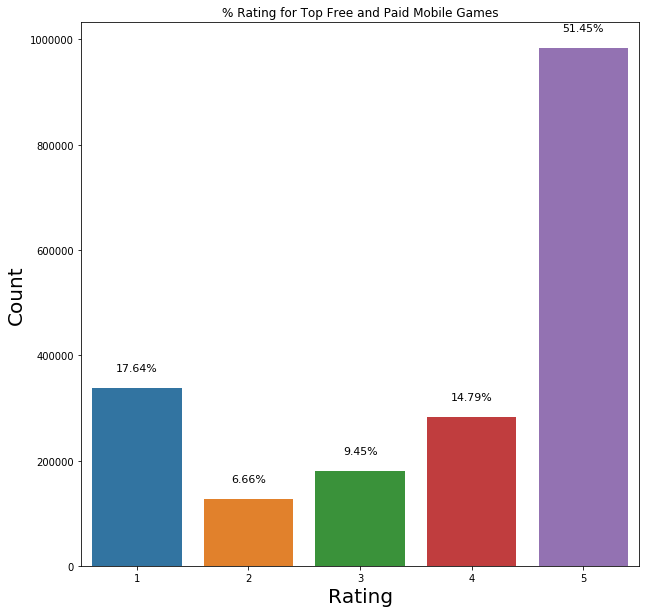

In [109]:
plt.figure(figsize=(10,10))

xaxis = ['1', '2', '3', '4', '5']
yaxis = [count1, count2, count3, count4, count5]
ax = sns.barplot(xaxis, yaxis)

plt.title('% Rating for Top Free and Paid Mobile Games')
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Rating', fontsize = 20)


for p in ax.patches:
             ax.annotate("%.2f" % (p.get_height()*100/total)+'%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')

In [50]:
# Separating reviews into their scores.

rating1 = dfreview.loc[dfreview['score'] == 1]
rating2 = dfreview.loc[dfreview['score'] == 2]
rating3 = dfreview.loc[dfreview['score'] == 3]
rating4 = dfreview.loc[dfreview['score'] == 4]
rating5 = dfreview.loc[dfreview['score'] == 5]

In [110]:
rating1.head(2)

,content,score
140,Reliable packet 1 (size=14) was not ack'd afte...,1
157,"I was having great fun playing this game, but ...",1


In [111]:
rating2.head(2)

,content,score
16,Thia should have been fun if bugs will be fixe...,2
75,This Game is so fun and enjoyable! I would pla...,2


In [112]:
rating3.head(2)

,content,score
3,"This game is great, but the more I play, the w...",3
5,"I think the game is really fun, but I do have ...",3


In [113]:
rating4.head(2)

,content,score
0,"It is an amazing and unique game, really liked...",4
1,I really like this game! I would love to see f...,4


In [114]:
rating5.head(2)

,content,score
2,I love the mystery and intrigue that Among Us ...,5
7,The game is a great and fun game that I would ...,5


### Tokenizing

In [153]:
# Turning dataframe of text into list for tokenizing.

rating1text = list(rating1['content'])
rating2text = list(rating2['content'])
rating3text = list(rating3['content'])
rating4text = list(rating4['content'])
rating5text = list(rating5['content'])

In [192]:
# Remove common words
stopwords_list = stopwords.words('english') + list(string.punctuation)
# Remove more punctuation
stopwords_list += ["''", '""', '...', '``']
# Remove random numerals
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# Remove contractions
stopwords_list += ["'d", "'ve", "'nt",  "'t", "'re", "'ll", "'s"]

In [193]:
def process_reviews(reviews):
    tokens = nltk.word_tokenize(reviews)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed    

In [194]:
# Testing if this function works
# It takes about 25 minutes to run 5 ratings.

processedreviewrating1 = [item for sublist in list(map(process_reviews, rating1text)) for item in sublist]
processedreviewrating2 = [item for sublist in list(map(process_reviews, rating2text)) for item in sublist]
processedreviewrating3 = [item for sublist in list(map(process_reviews, rating3text)) for item in sublist]
processedreviewrating4 = [item for sublist in list(map(process_reviews, rating4text)) for item in sublist]
processedreviewrating5 = [item for sublist in list(map(process_reviews, rating5text)) for item in sublist]

In [204]:
# Saving tokens into a sub-folder in for tidiness.

from pathlib import Path

root = Path('.')

my_path1 = root / "tokens" / "processedreviewrating1.pbz2"
my_path2 = root / "tokens" / "processedreviewrating2.pbz2"
my_path3 = root / "tokens" / "processedreviewrating3.pbz2"
my_path4 = root / "tokens" / "processedreviewrating4.pbz2"
my_path5 = root / "tokens" / "processedreviewrating5.pbz2"

import bz2

def compressed_pickle(path, data):
    with bz2.BZ2File(path, 'w') as f:
        pickle.dump(data, f)

compressed_pickle(my_path1, processedreviewrating1)
compressed_pickle(my_path2, processedreviewrating2)
compressed_pickle(my_path3, processedreviewrating3)
compressed_pickle(my_path4, processedreviewrating4)
compressed_pickle(my_path5, processedreviewrating5)